In [2]:
import cvxpy as cp
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

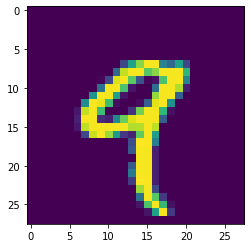

In [5]:
import gzip
f = gzip.open('train-images-idx3-ubyte.gz','r')

image_size = 28
num_images = 100

f.read(16)
buf = f.read(image_size * image_size * num_images)
data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
data = data.reshape(num_images, image_size, image_size, 1)
image = np.asarray(data[]).squeeze()
plt.imshow(image)

In [6]:
# 3 and 8 are both 1s
p1 = np.asarray(data[0]).squeeze()
p0 = np.asarray(data[4]).squeeze()
assert np.sum(p1) >= np.sum(p0)
norm_factor = max(np.sum(p1), np.sum(p0))
p1 = p1 / norm_factor
p0 = p0 / norm_factor
print(np.sum(p1), np.sum(p0))

1.0 0.8433788


In [478]:
def ddiv(a, b):
    n = 28
    dx = 1
    col0 = np.zeros((n,1))
    row0 = np.zeros((1,n))
    divm = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if i < n-1:
                divm[i,j] += a[i,j]
            if j < n-1:
                divm[i,j] += b[i,j]
            if i > 0:
                divm[i,j] -= a[i-1,j]
            if j > 0:
                divm[i,j] -= b[i,j-1]
            divm[i,j] /= dx
    return divm

In [7]:
n = 28
dx = 1/(n-1)
gamma = 0.7

mx = cp.Variable((n-1,n))
my = cp.Variable((n,n-1))
p0t = cp.Variable((n,n))
p1t = cp.Variable((n,n))
col0 = np.zeros((n,1))
row0 = np.zeros((1,n))

objective = cp.Minimize(cp.sum(cp.norm(cp.vstack([cp.vec(cp.hstack([my, col0])), cp.vec(cp.vstack([mx, row0]))]),axis=0)))

# Assumes that p1t has larger mass
constraints = [
    dx*(p0t - p1t) == cp.vstack([mx,row0])-cp.vstack([row0,mx])+cp.hstack([my,col0])-cp.hstack([col0,my]),
    p0t >= 0,
    p0t <= p0,
    p1t >= 0,
    p1t <= p1,
    cp.sum(p0t) == gamma,
    cp.sum(p1t) == gamma,
]

In [10]:
prob = cp.Problem(objective, constraints)
prob.solve()

0.046338761189318296

In [11]:
prob.solver_stats.solve_time/prob.solver_stats.num_iters

0.0029945542241379313

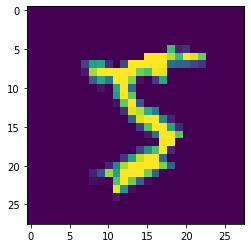

In [12]:
plt.imshow(p1t.value)

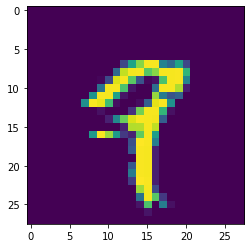

In [13]:
plt.imshow(p0t.value)

In [620]:
def solve_PMK(gamma, p0, p1):
    n = 28
    dx = 1

    mx = cp.Variable((n-1,n))
    my = cp.Variable((n,n-1))
    p0t = cp.Variable((n,n))
    p1t = cp.Variable((n,n))
    col0 = np.zeros((n,1))
    row0 = np.zeros((1,n))

    objective = cp.Minimize(cp.sum(cp.norm(cp.vstack([cp.vec(cp.hstack([my, col0])), cp.vec(cp.vstack([mx, row0]))]),axis=0)))

    # Assumes that p1t has larger mass
    constraints = [
        dx*(p0t - p1t) == cp.vstack([mx,row0])-cp.vstack([row0,mx])+cp.hstack([my,col0])-cp.hstack([col0,my]),
        p0t >= 0,
        p0t <= p0,
        p1t >= 0,
        p1t <= p1,
        cp.sum(p0t) == gamma,
        cp.sum(p1t) == gamma,
    ]
    prob = cp.Problem(objective, constraints)
    prob_val = prob.solve()
    return prob_val, p0t.value, p1t.value, mx.value, my.value

In [760]:
gammas = np.linspace(0, np.sum(p0)-0.001, num=20)
p_gammas = []
for gamma in gammas:
    print("Solving problem for", gamma)
    m, _, _, _, _ = solve_PMK(gamma, p0, p1)
    p_gammas.append(m)

Solving problem for 0.0
Solving problem for 0.03546326971054077
Solving problem for 0.07092653942108154
Solving problem for 0.10638980913162231
Solving problem for 0.14185307884216308
Solving problem for 0.17731634855270384
Solving problem for 0.21277961826324462
Solving problem for 0.2482428879737854
Solving problem for 0.28370615768432617
Solving problem for 0.3191694273948669
Solving problem for 0.3546326971054077
Solving problem for 0.3900959668159485
Solving problem for 0.42555923652648925
Solving problem for 0.46102250623703


/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Solving problem for 0.4964857759475708
Solving problem for 0.5319490456581115
Solving problem for 0.5674123153686523
Solving problem for 0.6028755850791931
Solving problem for 0.6383388547897338
Solving problem for 0.6738021245002747


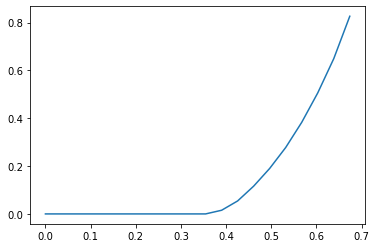

In [761]:
plt.plot(gammas, p_gammas)

In [711]:
def objective(mx, my, n):
    col0 = np.zeros((n,1))
    row0 = np.zeros((1,n))
    return np.sum(np.linalg.norm(np.vstack((np.hstack((my, col0)).T.flatten(), np.vstack((mx, row0)).T.flatten())),axis=0))

In [713]:
objective(mx.value, my.value, 28)

0.02592582013075749

In [714]:
cp.sum(cp.norm(cp.vstack([cp.vec(cp.hstack([my, col0])), cp.vec(cp.vstack([mx, row0]))]),axis=0)).value

0.02592582013075749

In [708]:
np.vstack((mx.value, row0)).T.flatten()-cp.vec(cp.vstack([mx, row0])).value
None

In [709]:
cp.vec(cp.vstack([mx, row0])).value
None

In [715]:
def discrete_div(mx, my, dx):
    col0 = np.zeros((n,1))
    row0 = np.zeros((1,n))
    return (np.vstack((mx,row0))-np.vstack((row0,mx))+np.hstack((my,col0))-np.hstack((col0,my))) / dx

In [728]:
discrete_div(mx.value,my.value,dx)-((cp.vstack([mx,row0])-cp.vstack([row0,mx])+cp.hstack([my,col0])-cp.hstack([col0,my])).value)/dx

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0

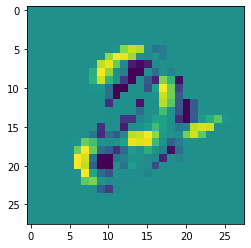

In [727]:
plt.imshow(((cp.vstack([mx,row0])-cp.vstack([row0,mx])+cp.hstack([my,col0])-cp.hstack([col0,my])).value)/dx)

In [757]:
def project_onto_density(sigma, rho, gamma, epsilon=1e-16):
    theta_min = -np.max(rho) + np.min(sigma)
    theta_max = np.max(sigma)
    theta_mid = None
    while theta_max - theta_min >= epsilon:
        theta_mid = (theta_max + theta_min) / 2
        rho_t = np.minimum(np.maximum(sigma-theta_mid,0),rho)
        if gamma < np.sum(rho_t):
            theta_min = theta_mid
        else:
            theta_max = theta_mid
    return np.minimum(np.maximum(sigma-theta_mid,0),rho)

In [762]:
a = project_onto_density(p1/2, p1, 0.99999994/2)

In [764]:
np.linalg.norm((a-p1/2).flatten())

5.9269007e-09

In [784]:
def shrink2(X, Y, mu, n):
    col0 = np.zeros((n,1))
    row0 = np.zeros((1,n))
    ghost = np.array([np.vstack((X, row0)), np.hstack((Y, col0))])
    norms = np.linalg.norm(ghost, axis=0)
    c = np.zeros_like(norms)
    c[norms >= mu] = 1 - mu/norms[norms >= mu]
#     c = np.maximum(1-mu/np.linalg.norm(ghost, axis=0),0)
    y = ghost*c
    return ghost, c, y[0,:-1,:], y[1,:,:-1]

In [785]:
a, c, _, _ = shrink2(mx.value, my.value, 0.0042866941015089165, 28)

In [786]:
np.linalg.norm(a, axis=0).shape

(28, 28)

In [811]:
norms = np.array([[2, 2], [0, 2]])
c = np.zeros_like(norms)
print(c)
mu = 0.5
c = 1 - mu/norms

[[0 0]
 [0 0]]


<ipython-input-811-22278f6bfea9>:5: RuntimeWarning: divide by zero encountered in true_divide
  c = 1 - mu/norms


In [813]:
np.maximum(c,0)

array([[0.75, 0.75],
       [0.  , 0.75]])